In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/PlantVillage.zip

Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/val/Soybean___healthy/55ed6b1f-9baf-45d9-b4b4-4f19c7dc271a___RS_HL 7312.JPG  
  inflating: PlantVillage/val/Soybean___healthy/561d3eaf-4ff0-4580-9958-55494bf3a88b___RS_HL 6420.JPG  
  inflating: PlantVillage/val/Soybean___healthy/56486310-1cd5-4fb4-9fb8-01f60417f64f___RS_HL 6258.JPG  
  inflating: PlantVillage/val/Soybean___healthy/56a8722c-1acf-4f63-ba8c-66df35f47791___RS_HL 6311.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5735f9f8-b5a4-42b4-b093-1e323323dfa2___RS_HL 3224.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5755b898-21db-4c7f-8d5a-3401e8478192___RS_HL 4530.JPG  
  inflating: PlantVillage/val/Soybean___healthy/578f7dd6-55ae-4fb3-8f79-3ee460250ea7___RS_HL 2784.JPG  
  inflating: PlantVillage/val/Soybean___healthy/57afa416-2cfd-49d0-9674-e59b7955648c___RS_HL 3367.JPG  
  inflating: PlantVillage/val/Soybean___healthy/57bac195-757a-4570-91fd-0da80dedc800___RS_HL 6641.JPG  
  inflating: 

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow.compat.v1.keras.backend as K


tf.compat.v1.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [27]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn import metrics

import matplotlib.pyplot as plt

In [4]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")


Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [5]:
root_dir = './PlantVillage'

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')


In [6]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [7]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(val_dir))


total images for training : ./PlantVillage/train : 44016files
total images for validation : ./PlantVillage/val : 11004files


In [8]:
import json

with open('/content/drive/MyDrive/categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [9]:
print('Number of classes:',len(classes))


Number of classes: 38


In [11]:
IMAGE_SHAPE = (224, 224)

BATCH_SIZE = 32


In [12]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    val_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)




Found 11004 images belonging to 39 classes.
Found 44016 images belonging to 39 classes.


In [25]:
width=224
height=224
depth=3
n_classes = 39


In [19]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5", 
                 output_shape=[2048],
                 trainable=False),
                 
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

In [28]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="valid",input_shape=(224,224,3)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="valid"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="valid"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="valid"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="valid"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [29]:
LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [31]:
EPOCHS=45 #@param {type:"integer"}

history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator)//BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=len(validation_generator)//BATCH_SIZE)

Epoch 1/45
43/43 [==============================] - 18s 412ms/step - loss: 2.7296 - accuracy: 0.3467 - val_loss: 6.6392 - val_accuracy: 0.0000e+00
Epoch 2/45
43/43 [==============================] - 17s 392ms/step - loss: 2.4770 - accuracy: 0.3852 - val_loss: 10.3758 - val_accuracy: 0.0000e+00
Epoch 3/45
43/43 [==============================] - 17s 392ms/step - loss: 2.3008 - accuracy: 0.4360 - val_loss: 15.0605 - val_accuracy: 0.0000e+00
Epoch 4/45
43/43 [==============================] - 17s 397ms/step - loss: 2.0759 - accuracy: 0.4658 - val_loss: 10.9566 - val_accuracy: 0.0000e+00
Epoch 5/45
43/43 [==============================] - 17s 392ms/step - loss: 1.9994 - accuracy: 0.4840 - val_loss: 10.4439 - val_accuracy: 0.0000e+00
Epoch 6/45
43/43 [==============================] - 17s 393ms/step - loss: 1.9277 - accuracy: 0.5000 - val_loss: 10.6870 - val_accuracy: 0.0437
Epoch 7/45
43/43 [==============================] - 17s 394ms/step - loss: 1.6936 - accuracy: 0.5552 - val_loss: 8.49

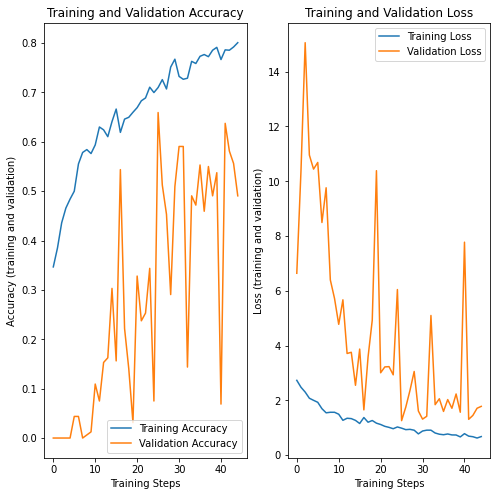

In [32]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pylab as plt

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(root_dir, val_dir, filename))
    assert not isinstance(img,type(None)), 'image not found'
    
    img = cv2.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]) )
  
    img = img /255
    
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

PREDICTED: class: Tomato___Early_blight, confidence: 0.678701


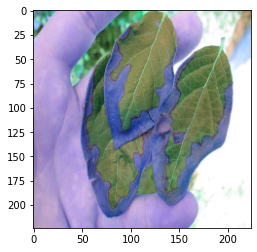

In [ ]:
img = load_image('/content/Drought_stress.jpeg')
prediction = predict(img)
print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
plt.imshow(img)
#plt.figure(idx)    
plt.show()


In [17]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("cn_model.h5")
model.save("inception_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = tf.keras.models.load_model("mobilenetv1_model.h5",custom_objects={'KerasLayer':hub.KerasLayer})
# summarize model.
model.summary()
# load dataset

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 39)                20007     
                                                                 
Total params: 2,933,863
Trainable params: 675,879
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
print(model.get_config())

{'name': 'sequential', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, None, None, None), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'keras_layer_input'}}, {'class_name': 'KerasLayer', 'config': {'name': 'keras_layer', 'trainable': False, 'dtype': 'float32', 'handle': 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4', 'output_shape': (1280,)}}, {'class_name': 'Dropout', 'config': {'name': 'dropout', 'trainable': True, 'dtype': 'float32', 'rate': 0.4, 'noise_shape': None, 'seed': None}}, {'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 512, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': '

In [ ]:
model.build((None, 224, 224, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 39)                20007     
                                                                 
Total params: 2,933,863
Trainable params: 675,879
Non-trainable params: 2,257,984
_________________________________________________________________
